# TEXT TO DISEASE! 📋➡️👨‍⚕️

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')

In [20]:
df = pd.read_csv('datasets/Symptom2Disease.csv').iloc[:, 1:]
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [21]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

C:\Users\inigo\AppData\Local\Temp\ipykernel_15904\3039307885.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = df['label'], palette = 'Blues_d')


Text(0.5, 1.0, 'Count of each disease')

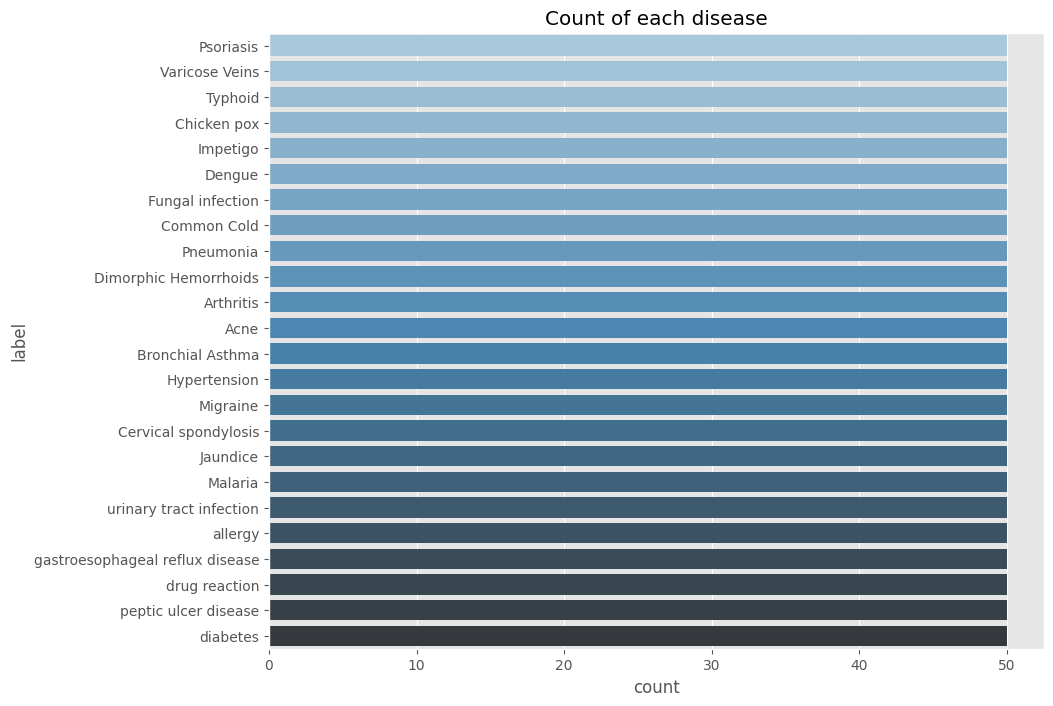

In [22]:
plt.figure(figsize = (10, 8))

sns.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

In [23]:
df['label'] = df['label'].astype("category")
df['text'] = df['text'].astype("str")

In [24]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize(batch):
    return tokenizer(batch["title"], padding=True, truncation=True)

In [25]:
def undersample_and_split_dataframe(df, class_column, split_prob=[0.7, 0.15, 0.15]):

    #split parameters
    choices = ['train', 'test', 'val']

    # Group by class and find the smallest class size
    group = df.groupby(class_column)
    smallest_class_size = group.size().min()

    # Sample from each class (we can use with multi-label)
    undersampled_df = pd.DataFrame()
    for _, group_df in group:
        sampled_df = group_df.sample(n=smallest_class_size, replace=False, random_state=1)

        # Perform the split class by class, for the train, test and validation rows to be balanced.
        sampled_df['split'] = np.random.choice(choices, size=len(sampled_df), p=split_prob)
        undersampled_df = pd.concat([undersampled_df, sampled_df], axis=0)

    # Check the distribution
    print(undersampled_df['split'].value_counts(normalize=True))

    return undersampled_df

In [26]:
split_df = undersample_and_split_dataframe(df, 'label')

split
train    0.699167
test     0.160833
val      0.140000
Name: proportion, dtype: float64


C:\Users\inigo\AppData\Local\Temp\ipykernel_15904\2618504654.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(class_column)


In [27]:
from datasets import Dataset, DatasetDict

train_df = split_df[split_df.split=='train']
eval_df = split_df[split_df.split=='val']
test_df = split_df[split_df.split=='test']

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.class_encode_column('category')
eval_dataset = eval_dataset.class_encode_column('category')
test_dataset = test_dataset.class_encode_column('category')

dataset_dict = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset,
    'test': test_dataset
})

print(dataset_dict)
print(dataset_dict['train'].features)

NotImplementedError: 

In [8]:

train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

#Antes lo habíamos pasado a pandas, volvemos a pasarlo a torch
dataset_dict.set_format(type="torch")

#Transformarmamos todo el dataset (los 3 splits) a token_ids.
news_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

c:\Users\inigo\anaconda3\envs\HPE\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
pip install keras --upgrade

Note: you may need to restart the kernel to use updated packages.


In [14]:
from transformers import AutoModelForSequenceClassification

num_classes = 24

model = AutoModelForSequenceClassification.from_pretrained(
             "bert-base-cased", 
             num_labels = num_classes, 
             id2label = int2label, 
             label2id = label2int,
             output_attentions = True
        ).to("cpu")

model

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


## Train the model!

In [ ]:
EPOCHS = 3

history = model.fit(train_dataset, 
          epochs = EPOCHS, 
          validation_data = val_dataset)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Now it's ready to use!

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)

def predict_disease(text : str) -> str:
    return pipe(text)[0][:2]

In [ ]:
text1 = "I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. "
text2 = "I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting \
    worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever."

In [ ]:
print(predict_disease(text1))
print(predict_disease(text2))